In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as nl
import copy
from Importer import NodeImporter, ElementImporter

In [3]:
class Hyperelastic:
	def __init__(self):

		self.materialprops=np.array([[80.1938],[120.291]])
		#self.keypoint=np.array([[0,0],[self.L,0],[self.L,self.D],[0,self.D]])
		#self.line=np.array([[1,2],[2,3],[3,4],[4,1]])
		self.bactudo=2
		self.nnx = 20
		self.nny = 50
		self.ndof=2
		self.ncoord=2
		self.Force=np.array([[1,0,10000,0]])
		#self.node=self.meshing(self.keypoint,self.nnx,self.nny)
		self.node = NodeImporter("NLIST2.txt").importNode()
		self.L = 10
		self.D = 10
		self.numnode=self.node.shape[0]
		#self.element=self.CreateElement(np.array([0,1,self.nnx+1,self.nnx]),self.nnx-1,self.nny-1,1,self.nnx)
		self.element = ElementImporter("ELIST2.txt").importElement()
		#print(self.node)
		#print(self.element)
		self.topNodes,self.botNodes=self.locateNodes(self.node,self.L,self.D)
		self.dmax=1.8
		#self.deltaX=self.L/(self.nnx-1)
		#self.deltaY=self.D/(self.nny-1)
		self.delta=0.1
		self.di=np.ones((1,self.numnode))*self.dmax*self.delta
		self.eta=4.01
		#self.Q,self.W,self.Jacobi=self.Gauss(self.element,self.node)
		#self.numGauss=self.Q.shape[0]
		self.fixNodes,self.dload=self.applyConstrain(self.botNodes,self.topNodes)
		self.nfix=self.fixNodes.shape[1]
		self.nG = 2
		#self.plotmesh=self.Plotmesh(self.node,self.element)
		

	def Calculate(self):
		self.line,self.limit = self.getModelProperty()
		self.Q,self.W,self.Jacobi=self.auxiliaryDomain(self.line,self.limit,self.nny,self.nnx,self.nG,self.nG)
		self.numGauss = self.Q.shape[0]
		self.w=self.NewtonRaphson(self.numnode,self.ndof,self.ncoord,self.node,self.materialprops,self.numGauss,self.Q,self.Jacobi,self.W,self.di,self.eta,self.topNodes,self.nfix,self.fixNodes)
		self.defnode=self.Deformation(self.w,self.node,self.numnode,self.ndof)
		self.stress=self.stresssolver(self.node,self.numnode,self.ndof,self.ncoord,self.eta,self.w,self.di,self.materialprops)
		self.plotstress(self.defnode,self.stress,self.element,self.numnode)

	def getModelProperty(self):
		arc2 = []
		arc4 = []
		arc1 = self.node[self.botNodes[:],:]
		for i in range(self.node.shape[0]):
			if abs((self.node[i,0])**2+(self.node[i,1])**2-9**2)<1e-4:
				arc2 = arc2+[self.node[i,:]]
			elif abs((self.node[i,0])**2+(self.node[i,1])**2-10**2)<1e-4:
				arc4 = arc4+[self.node[i,:]]
		arc2=np.array(arc2)
		arc4 = np.array(arc4)
		arc3 = self.node[self.topNodes[:],:]
		sortarc1 = sorted(arc1[:,0])
		sortarc2 = sorted(arc2[:,0])
		sortarc3 = sorted(arc3[:,1])
		sortarc4 = sorted(arc4[:,0],reverse=True)
		buffarc1 = np.zeros((arc1.shape[0]))
		buffarc2 = np.zeros((arc2.shape[0]))
		buffarc3 = np.zeros((arc3.shape[0]))
		buffarc4 = np.zeros((arc4.shape[0]))
		for j in range(len(sortarc1)):
			for i in range(arc1.shape[0]):
				if abs(arc1[i,0]-sortarc1[j])<1e-4:
					buffarc1[j] = i
					break
		buffarc1 = buffarc1.astype(int)
		sortarc1 = arc1[buffarc1[:],:]
		for j in range(len(sortarc2)):
			for i in range(arc2.shape[0]):
				if abs(arc2[i,0]-sortarc2[j])<1e-4:
					buffarc2[j] = i
					break
		buffarc2 = buffarc2.astype(int)
		sortarc2 = arc2[buffarc2[:],:]

		for j in range(len(sortarc3)):
			for i in range(arc3.shape[0]):
				if abs(arc3[i,1]-sortarc3[j])<1e-4:
					buffarc3[j] = i
					break
		buffarc3 = buffarc3.astype(int)
		sortarc3 = arc3[buffarc3[:],:]

		for j in range(len(sortarc4)):
			for i in range(arc4.shape[0]):
				if abs(arc4[i,0]-sortarc4[j])<1e-4:
					buffarc4[j] = i
					break
		buffarc4 = buffarc4.astype(int)
		sortarc4 = arc4[buffarc4[:],:]

		limit = np.zeros((sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+sortarc4.shape[0]-4,4))
		L1 = np.zeros((sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+sortarc4.shape[0]-4, 3))
		Lx = np.zeros((sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+sortarc4.shape[0]-4, 2))
		Ly = np.zeros((sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+sortarc4.shape[0]-4, 2))
		for i in range(sortarc1.shape[0] - 1):
			L1[i, :], Lx[i, :], Ly[i, :] = self.line2(np.array(sortarc1[i, :]), np.array(sortarc1[i + 1,:]))
		for i in range(sortarc2.shape[0]- 1):
			L1[sortarc1.shape[0]-1+i, :], Lx[sortarc1.shape[0]-1+i, :], Ly[sortarc1.shape[0]+i-1, :] = self.line2(np.array(sortarc2[i, :]), np.array(sortarc2[i + 1,:]))
		for i in range(sortarc3.shape[0] - 1):
			L1[sortarc1.shape[0]+sortarc2.shape[0]+i-2, :], Lx[sortarc1.shape[0]+sortarc2.shape[0]+i-2, :], Ly[sortarc1.shape[0]+sortarc2.shape[0]+i-2, :] = self.line2(np.array(sortarc3[i, :]), np.array(sortarc3[i + 1,:]))
		for i in range(sortarc4.shape[0] - 1):
			L1[sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+i-3, :], Lx[sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+i-3, :], Ly[sortarc1.shape[0]+sortarc2.shape[0]+sortarc3.shape[0]+i-3, :] = self.line2(np.array(sortarc4[i, :]), np.array(sortarc4[i + 1,:]))
		limit[:,0:2] = Lx[:]
		limit[:,2:4] = Ly[:]
		return L1,limit

	def line2(self,A,B):
		equation=np.zeros((1,3))
		xlim = np.zeros((1,2))
		ylim = np.zeros((1,2))
		equation[0,0],equation[0,1],equation[0,2]=self.eq2Point(A,B)
		xlim[0,0]=min(A[0],B[0])
		xlim[0,1]=max(A[0],B[0])
		ylim[0,0]=min(A[1],B[1])
		ylim[0,1]=max(A[1],B[1])
		return equation,xlim,ylim
	
	def auxiliaryDomain(self,Line,Limit,nny,nnx,nGX,nGY):
		xmin = min(Limit[:,0])
		xmax = max(Limit[:,1])
		ymin = min(Limit[:,2])
		ymax = max(Limit[:,3])
		matPoint1 = np.zeros((nny,2))
		matPoint2 = np.zeros((nny,2))
		equationLB = np.zeros((nny,3))
		Y = np.array(np.linspace(ymin,ymax,nny))
		matPoint1[:,0:1] = np.ones((len(Y),1))*xmin
		matPoint1[:,1] = Y.T
		matPoint2[:, 0:1] = np.ones((len(Y), 1)) * xmax
		matPoint2[:, 1] = Y.T
		#matPoint1 = np.array([(np.ones((len(Y),1))*xmin).T,Y.T]).T
		#matPoint2 = [np.ones((len(Y), 1)) * xmax, Y.T]
		for i in range(len(Y)):
			equationLB[i,0],equationLB[i,1],equationLB[i,2]=self.eq2Point(np.array(matPoint1[i,:]),np.array(matPoint2[i,:]))
		xlimLB = np.zeros((nny,2))
		ylimLB = np.zeros((nny,2))
		xlimLB[:, 0:1] = np.ones((nny,1))*xmin
		xlimLB[:, 1:2] = np.ones((nny,1))*xmax
		ylimLB[:, 0] = Y.T
		ylimLB[:, 1] = Y.T
		element =np.zeros((nny-1,2))
		for i in range(nny-1):
			element[i,0]=i
			element[i,1]=i+1
		q, w = self.quadrature(nGY, 'GAUSS', 1)
		wy = np.zeros(((nny-1)*nGY,1))
		qy = np.zeros(((nny-1)*nGY,2))
		jy = np.zeros((1,(nny-1)*nGY))
		P = matPoint1
		for e in range(element.shape[0]):
			sctr = element[e,:]
			sctr = sctr.astype(int)
			for i in range(w.shape[0]):
				pt = q[i,:]
				wt = w[i]
				N,dNdxi = self.lagrange_basis('L2',pt)
				#print(np.array([P[sctr,0],P[sctr,1]]))
				#print(P[sctr,0])
				temp =np.zeros((2,2))
				temp[:,0] = P[sctr,0]
				temp[:,1] = P[sctr,1]
				qy[e*nGY+i,:] = (N.T).dot(temp)
				wy[e*nGY+i] = wt
				jy[0,e*nGY+i] = (P[sctr[1],1]-P[sctr[0],1])/2
		P1 = np.zeros((qy.shape[0],2))
		P1[:,1] = qy[:,1]
		P1[:, 0] = np.ones((qy.shape[0]))*xmin
		#print(np.ones((qy.shape[0]))*xmin)
		P2 = np.zeros((qy.shape[0], 2))
		P2[:,1] = qy[:,1]
		P2[:, 0] = np.ones((qy.shape[0]))*xmax
		equationLB=np.zeros((P1.shape[0],3))
		for i in range(P1.shape[0]):
			equationLB[i,0],equationLB[i,1],equationLB[i,2]=self.eq2Point(P1[i,:],P2[i,:])
		zP1=P1.shape[0]
		xlimLB=np.zeros((zP1,2))
		ylimLB=np.zeros((zP1,2))
		xlimLB[:,0]=np.ones((zP1))*xmin
		xlimLB[:,1]=np.ones((zP1))*xmax
		ylimLB[:,0]=P1[:,1]
		ylimLB[:,1]=P1[:,1]
		k=0
		nx = []
		ny = []

		#nx = float('inf')
		#nny = float('inf')
		LB=equationLB
		element1Dtem = np.zeros((LB.shape[0], 2))

		xLB=xlimLB
		yLB=ylimLB
		for i in range(LB.shape[0]):
			h = 0
			for j in range(Line.shape[0]):
				temp = np.zeros((1,4))
				temp[0,0:2] = xLB[i,:]
				temp[0,2:4] = yLB[i,:]
				limit = np.zeros((1,4))
				limit[0,:]=Limit[j,:]
				x,y = self.solu2(Line[j,:],limit,LB[i,:],temp)
				buff = np.zeros((len(nx),2))
				buff[:,0] = nx
				buff[:,1] = ny
				f = self.find2(buff,np.array([[x,y]]))
				if x!='empty' and f==0:
					nx.append(x)
					ny.append(y)
					element1Dtem[i,h]=k
					h += 1
					k += 1
		element1Dtem=element1Dtem.astype(int)
		node=np.array([nx,ny]).T
		nx = np.array([nx])
		ny = np.array([ny])
		for i in range(element1Dtem.shape[0]):
			pQ=np.array([element1Dtem[i,:]])
			if (pQ.shape[1]>1):
				element1Dtem[i,:]=self.min2max(nx[0,pQ],pQ)
		ii=0
		jytem = jy
		wytem = wy
		element1D=np.zeros((element1Dtem.shape[0],2))
		for i in range(element1Dtem.shape[0]):
			pQ = np.array([element1Dtem[i, :]])
			for j in range(pQ.shape[1]):
				if j%2==1:
					element1D[ii,:]=pQ[0,:]
					jy[0,ii]=jytem[0,i]
					wy[ii,0]=wytem[i,0]
					ii += 1
		element1D = element1D.astype(int)
		lengthElement1D = np.zeros((1,element1D.shape[0]))
		#lengthElement1D = math.sqrt((nx[0,element1D[:,0]] - nx[0,element1D[:,1]])**2 + (ny[0,element1D[:,0]]-ny[0,element1D[:,1]])**2)
		for i in range(element1D.shape[0]):
			lengthElement1D[0,i]=math.sqrt((nx[0,element1D[i,0]] - nx[0,element1D[i,1]])**2 + (ny[0,element1D[i,0]]-ny[0,element1D[i,1]])**2)
		Lmean = np.mean(lengthElement1D)
		nDivide = np.fix(((nnx-1)*lengthElement1D/Lmean))
		nDivide = nDivide.astype(int)
		for i in range(nDivide.shape[1]):
			if nDivide[0,i]==0:
				nDivide[0,i]=1
		element1Dtem=element1D
		element1D = []
		for i in range(lengthElement1D.shape[1]):
			if nDivide[0,i]>=2:
				matX = np.linspace(nx[0,element1Dtem[i,0]],nx[0,element1Dtem[i,1]],nDivide[0,i]+1)
				matY = np.linspace(ny[0,element1Dtem[i,0]],ny[0,element1Dtem[i,1]],nDivide[0,i]+1)
				sBefore = node.shape[0]
				c = np.array([matX[1:-1],matY[1:-1]]).T
				node = np.append(node,c,axis=0)
				nTem = np.append(element1Dtem[i,0],np.arange(sBefore,node.shape[0]))
				nTem = np.append(nTem, np.array([element1Dtem[i, 1]]))
				for j in range(len(nTem)-1):
					buff = np.array([[nTem[j],nTem[j+1]]])
					element1D.append(np.array([[nTem[j],nTem[j+1]]]))
			else:
				element1D.append(element1Dtem[i,:])
		arrElement1D=np.zeros((len(element1D),2))
		for i in range(len(element1D)):
			arrElement1D[i,:]=element1D[i]
		q,w = self.quadrature(nGX,'GAUSS',1)
		wx = np.zeros((arrElement1D.shape[0] * nGX, 1))
		qx = np.zeros((arrElement1D.shape[0] * nGX, 2))
		jx = np.zeros((arrElement1D.shape[0] * nGX, 1))
		nx = np.array([node[:,0]])
		ny = np.array([node[:,1]])
		for e in range(arrElement1D.shape[0]):
			sctr = arrElement1D[e,:]
			sctr = sctr.astype(int)
			for i in range(w.shape[0]):
				pt = q[i, :]
				wt = w[i]
				N, dNdxi = self.lagrange_basis('L2', pt)
				temp = np.zeros((2, 2))
				temp[:, 0] = nx[0,sctr]
				temp[:, 1] = ny[0,sctr]
				qx[e * nGX + i, :] = (N.T).dot(temp)
				wx[e * nGX + i] = wt
				jx[ e * nGY + i,0] = (nx[0,sctr[1]] - nx[0,sctr[0]]) / 2
		Jy = []
		for i in range(nDivide.shape[1]):
			Jy.append(np.ones((nDivide[0,i]*nGX,1))*jy[0,i])
		listJy = []
		for i in range(len(Jy)):
			for j in range(Jy[i].shape[0]):
				listJy.append(Jy[i][j,0])
		arrJy = np.array(([listJy])).T

		Wy = []
		for i in range(nDivide.shape[1]):
			Wy.append(np.ones((nDivide[0, i] * nGX, 1)) * wy[i,0])
		listWy = []
		for i in range(len(Wy)):
			for j in range(Wy[i].shape[0]):
				listWy.append(Wy[i][j, 0])
		arrWy = np.array(([listWy])).T
		Q = qx
		J = np.zeros((jx.shape[0],2))
		W = np.zeros((wx.shape[0],2))
		J[:,0:1] = jx
		J[:,1:2] = arrJy
		W[:,0:1] = wx
		W[:,1:2] = arrWy
		return Q,W,J
	def min2max(self,x,ii):
		for j in range(x.shape[1]-1):
			if x[0,j]>x[0,j+1]:
				iitem=ii[0,j]
				ii[0,j]=ii[0,j+1]
				ii[0,j+1]=iitem
		return ii
	def find2(self,A,x):
		f1 = []
		f2 = []
		for i in range(len(A)):
			if A[i,0]==x[0,0]:
				f1.append(i)
		for i in range(len(A)):
			if A[i,1]==x[0,1]:
				f2.append(i)
		index = 0
		get =0
		if len(f1)!=0:
			for i in range(len(f1)):
				for j in range(len(f2)):
					if f2[j]==f1[i]:
						index = i
						get = 1
						break
				if get==1:
					break
		else:
			index = 0
		return index

	def solu2(self,eq1,cd1,eq2,cd2):
		A = np.array([[eq1[0], eq1[1]],[eq2[0],eq2[1]]])
		if np.linalg.det(A)!=0 and np.linalg.det(A)!= float('nan'):
			B = np.array([-eq1[2],-eq2[2]])
			invA = np.linalg.inv(A)
			#print(invA.dot(B))
			re=np.matrix.round(invA.dot(B),10)
			#print(cd1[0])

			xmin = max(cd1[0,0], cd2[0,0]) - 1e-8
			xmax = min(cd1[0,1], cd2[0,1]) + 1e-8
			ymin = max(cd1[0,2], cd2[0,2]) - 1e-8
			ymax = min(cd1[0,3], cd2[0,3]) + 1e-8
			if re[0]>=xmin and re[0]<=xmax and re[1]>=ymin and re[1]<=ymax:
				x = re[0]
				y = re[1]
			else:
				x = 'empty'
				y = 'empty'
		else:
			x = 'empty'
			y = 'empty'
		return x,y
	def eq2Point(self,A,B):
		AB = B-A
		lengthAB = math.sqrt(AB[0]**2+AB[1]**2)
		a = -(B[1]-A[1])/lengthAB
		b = (B[0]-A[0])/lengthAB
		c = (A[0]*(B[1]-A[1])-A[1]*(B[0]-A[0]))/lengthAB
		return a,b,c
	def plotstress(self,defnode,stress,element,numnode):
		stressx=np.zeros((defnode.shape[0],1))
		stressy=np.zeros((defnode.shape[0],1))
		tauxy=np.zeros((defnode.shape[0],1))
		for i in range(defnode.shape[0]):
			stressx[i,:]=stress[0,0,i]
			stressy[i,:]=stress[1,1,i]
			tauxy[i,:]=stress[0,1,i]
		ele3 = np.array(element[:, [0, 1, 2]].tolist() + element[:, [0, 2, 3]].tolist())
		fig2, ax2 = plt.subplots()
		plt.set_cmap('jet')
		ax2.set_aspect("equal")
		spec = ax2.tricontourf(defnode[:,0],defnode[:,1],ele3,stressx[:,0], 1000)
		fig2.colorbar(spec, use_gridspec=True, orientation='horizontal')
		plt.title('sigma x')
		plt.box('off')
		plt.axis('off')

		fig2, ax2 = plt.subplots()
		plt.set_cmap('jet')
		ax2.set_aspect("equal")
		spec = ax2.tricontourf(defnode[:,0],defnode[:,1],ele3,stressy[:,0], 1000)
		fig2.colorbar(spec, use_gridspec=True, orientation='horizontal')
		plt.title('sigma y')
		plt.box('off')
		plt.axis('off')

		fig2, ax2 = plt.subplots()
		plt.set_cmap('jet')
		ax2.set_aspect("equal")
		spec = ax2.tricontourf(defnode[:,0],defnode[:,1],ele3,tauxy[:,0], 1000)
		fig2.colorbar(spec, use_gridspec=True, orientation='horizontal')
		plt.title('tauxy')
		plt.box('off')
		plt.axis('off')

		fig2, ax2 = plt.subplots()
		plt.set_cmap('jet')
		ax2.set_aspect("equal")
		vonmises=self.VonmisesStress(stressx,stressy,tauxy,numnode)
		spec = ax2.tricontourf(defnode[:,0],defnode[:,1],ele3,vonmises[:,0], 1000)
		fig2.colorbar(spec, use_gridspec=True, orientation='horizontal')
		plt.title('Vonmises Stress')
		plt.box('off')
		plt.axis('off')

		plt.show()

	def VonmisesStress(self,stressx,stressy,tauxy,numnode):
		vonmises = np.zeros((numnode,1))
		for i in range(numnode):
			I1 = stressx[i,0]+stressy[i,0]
			I2 = stressx[i,0]*stressy[i,0]-tauxy[i,0]**2
			I3 = 0
			r = np.roots([1,-I1,I2,-I3])
			sig1 = r[0]
			sig2 = r[1]
			sig3 = r[2]
			vm = np.sqrt(sig1**2+sig2**2+sig3**2-sig1*sig2-sig1*sig3-sig3*sig2)
			vonmises[i,0] = vm
		return vonmises

	def stresssolver(self,node,numnode,ndof,ncoord,eta,w,di,materialprops):
		stress=np.zeros((2,2,numnode))
		for l in range(numnode):
			pt=np.array([node[l,:]])
			index=self.define_support(node,pt,di)
			c = 0.02
			while index.shape[1] < 8:
				count = di + c
				index = self.define_support(node, pt, count)
				c = c + 0.02
			nn=index.shape[1]
			phi,dphidx,dphidy=self.RPIM_shape_2D_TPS(pt,node.T,index,eta)
			lmndof=np.zeros((ndof,nn))
			for m in range(nn):
				lmndof[0,m]=w[ndof*index[0,m],:]
				lmndof[1,m]=w[ndof*index[0,m]+1,:]
			dphidxglobal = np.zeros((2,nn))
			dphidxglobal[0,:]=dphidx
			dphidxglobal[1,:]=dphidy
			dphidxglobal=dphidxglobal.T
			F=np.dot(lmndof,dphidxglobal)
			for i in range(ncoord):
				for j in range(ncoord):
					if i==j:
						F[i,j]=F[i,j]+1.
			J=nl.det(F)
			B=np.dot(F,F.T)
			stress[:,:,l]=self.KirchoffStress(ndof,ncoord,B,J,materialprops)/J
		return stress

	def Deformation(self,w,node,numnode,ndof):
		defnode=np.zeros((numnode,ndof))
		scalefactor=1
		for i in range(numnode):
			for j in range(ndof):
				defnode[i,j]=node[i,j]+scalefactor*w[ndof*i+j]
		return defnode

	def NewtonRaphson(self,numnode,ndof,ncoord,node,materialprops,numGauss,Q,Jacobi,W,di,eta,topNodes,nfix,fixNodes):
		nsteps=20
		w = np.zeros((numnode*ndof,1))
		#nsteps=5
		tol=0.0001
		maxit=30
		relax=1

		forcevdisp=np.zeros((2,nsteps+1))
		forcevdisp[0,0]=0
		forcevdisp[1,0]=0

		for step in range(1,nsteps+1):
			loadfactor = step/nsteps
			err1=1.
			nit=0
			print('\nStep', step, 'Load',loadfactor)
			while ((err1>tol) and (nit<maxit)):
				nit=nit+1
				K=self.globalstiffness(ncoord,ndof,node,materialprops,w,numGauss,Q,Jacobi,W,di,eta,numnode)
				F=self.globaltraction(ncoord,ndof,numnode,node,self.topNodes,di,eta)
				R=self.globalresidual(ncoord,ndof,numnode,node,materialprops,w,numGauss,di,eta,Q,W,Jacobi)
				b=loadfactor*F-R
				for n in range(nfix):
					rw1=ndof*(fixNodes[0,n])+fixNodes[1,n]
					rw=rw1.astype(int)
					for cl in range(ndof*numnode):
						K[rw,cl]=0
						K[cl,rw]=0
					K[rw,rw]=1
					b[rw]=loadfactor*fixNodes[2,n]-w[rw]
				dw=np.dot(nl.inv(K),b)
				w=w+relax*dw
				wnorm=0
				err1=0
				err2=0
				for it in range(numnode*ndof):
					wnorm=wnorm+w[it,:]*w[it,:]
					err1=err1+dw[it,:]*dw[it,:]
					err2=err2+b[it,:]*b[it,:]
				err1=math.sqrt(err1/wnorm)
				err2=math.sqrt(err2)/(ndof*numnode)
				print('Iteration number',nit,'Correction',err1,'Residual',err2,'tolerance',tol)

		return w
	def globalresidual(self,ncoord,ndof,nnodes,node,materialprops,dofs,numGauss,di,eta,Q,W,Jacobi):
		resid = np.zeros((ndof*nnodes,1))
		for ind in range(numGauss):
			pt=np.array([Q[ind,:]])
			jac=Jacobi[ind,0]*Jacobi[ind,1]
			supportIndex=self.define_support(node,pt,di)
			c = 0.02
			while supportIndex.shape[1] < 8:
				count = di + c
				supportIndex = self.define_support(node, pt, count)
				c = c + 0.02
			nN=supportIndex.shape[1]
			phi,dphidx,dphidy=self.RPIM_shape_2D_TPS(pt,node.T,supportIndex,eta)
			lmncoord=np.zeros((ncoord,nN))
			weight=W[ind,0]*W[ind,1]
			lmndof=np.zeros((ndof,nN))
			entry=np.zeros((1,ndof*nN))
			for m in range(nN):
				lmncoord[:,m]=node[supportIndex[0,m],:]
				lmndof[0,m]=dofs[ndof*supportIndex[0,m],:]
				lmndof[1,m]=dofs[ndof*supportIndex[0,m]+1,:]
				entry[0,2*m]=2*supportIndex[0,m]
				entry[0,2*m+1]=2*supportIndex[0,m]+1
			entry1=entry.astype(int)
			rel=self.elresid(ncoord,ndof,lmncoord,materialprops,lmndof,nN,dphidx,dphidy,jac,weight)
			for a in range(nN):
				for i in range(ndof):
					rw=ndof*(supportIndex[0,a])+i
					resid[rw,0]=resid[rw,0]+rel[ndof*a+i,0]
		return resid
	def elresid(self,ncoord,ndof,coord,materialprops,displacement,nN,dphidx,dphidy,jac,weight):
		rel=np.zeros((ndof*nN,1))
		dphidxglobal = np.zeros((2,nN))
		dphidxglobal[0,:]=dphidx
		dphidxglobal[1,:]=dphidy
		dphidxglobal=dphidxglobal.T
		F=np.dot(displacement,dphidxglobal)
		for i in range(ncoord):
			for j in range(ncoord):
				if i==j:
					F[i,j]=F[i,j]+1.
		J=nl.det(F)
		B=np.dot(F,F.T)
		Finv=nl.inv(F)
		dphidxs=np.zeros((nN,2))
		for a in range(nN):
			for i in range(ncoord):
				for j in range(ncoord):
					dphidxs[a,i]=dphidxs[a,i]+dphidxglobal[a,j]*Finv[j,i]
		stress=self.KirchoffStress(ndof,ncoord,B,J,materialprops)
		for a in range(nN):
			for i in range(ndof):
				row=ndof*(a)+i
				for j in range(ncoord):
					rel[row,0]=rel[row,0]+stress[i,j]*dphidxs[a,j]*weight*jac
		return rel

	def globaltraction(self,ncoord,ndof,nnodes,node,topNodes,di,eta):
		r = np.zeros((ndof*nnodes,1))
		traction=np.zeros((ndof,1))
		Q1,W1=self.quadrature(4,'GAUSS',1)
		Wt = []
		#Qt = []
		Qt = np.zeros(((len(topNodes)-1)*4,2))
		Jt = []
		n=len(topNodes)-1
		m=W1.shape[0]
		for i in range(len(topNodes)-1):
			sctr=np.array([topNodes[i],topNodes[i+1]])
			for q in range(W1.shape[0]):
				pt=Q1[q,:]
				wt=W1[q]
				N,dNdxi=self.lagrange_basis('L2',pt)
				J0=np.dot(dNdxi.T,node[sctr,:])
				#Qt.append(np.dot(N.T,node[sctr,:]))
				temp = np.zeros((2, 2))
				temp[:, 0] = node[sctr, 0]
				temp[:, 1] = node[sctr, 1]
				Qt[i * 4 + q, :] = (N.T).dot(temp)
				Wt.append(wt)
				Jt.append(nl.norm(J0))
		Qt=np.array(Qt)
		Wt=np.array(Wt)
		Jt=np.array([Jt]).T
		for igp in range(Wt.shape[0]):
			pt=np.array([Qt[igp,:]])
			wt=Wt[igp,0]
			detJ=Jt[igp,0]
			index=self.define_support(node,pt,di)
			c = 0.02
			while index.shape[1] < 8:
				count = di + c
				index = self.define_support(node, pt, count)
				c = c + 0.02
			nN=index.shape[1]
			lmncoord=np.zeros((ncoord,nN))
			lmndof=np.zeros((ndof,nN))
			sctry=2*index.T+1
			sctry2 = 2 * index.T
			phi,dphidx,dphidy=self.RPIM_shape_2D_TPS(pt,node.T,index,eta)
			sigmato=-0.5*0.70710678
			r[sctry,0]=r[sctry,0]+phi.T*sigmato*detJ*wt
			r[sctry2, 0] = r[sctry2, 0] + phi.T * sigmato * detJ * wt
		return r

	def globalstiffness(self,ncoord,ndof,node,materialprops,dofs,numGauss,Q,Jacobi,W,di,eta,numnode):
		tdof=ndof*numnode
		K=np.zeros((tdof,tdof))
		for ind in range(numGauss):
			pt=np.array([Q[ind,:]])
			jac=Jacobi[ind,0]*Jacobi[ind,1]
			weight=W[ind,0]*W[ind,1]
			supportIndex=self.define_support(node,pt,di)
			c=0.02
			while supportIndex.shape[1]<8:
				count = di+c
				supportIndex=self.define_support(node,pt,count)
				c=c+0.02
			nN=supportIndex.shape[1]
			phi,dphidx,dphidy=self.RPIM_shape_2D_TPS(pt,node.T,supportIndex,eta)
			lmncoord=np.zeros((ncoord,nN))
			lmndof=np.zeros((ndof,nN))
			entry=np.zeros((1,ndof*nN))
			for m in range(nN):
				lmncoord[:,m]=node[supportIndex[0,m],:]
				lmndof[0,m]=dofs[ndof*supportIndex[0,m],:]
				lmndof[1,m]=dofs[ndof*supportIndex[0,m]+1,:]
				entry[0,2*m]=2*supportIndex[0,m]
				entry[0,2*m+1]=2*supportIndex[0,m]+1
			entry1=entry.astype(int)
			Kel=self.elstif(ncoord,ndof,nN,lmncoord,materialprops,lmndof,dphidx,dphidy,weight,jac)
			K=self.assembleK(K,Kel,entry1)
		return K
	def assembleK(self,K,Ke,b):
		for ind in range(b.shape[1]):
			for jind in range(b.shape[1]):
				K[b[0,ind],b[0,jind]]=K[b[0,ind],b[0,jind]]+Ke[ind,jind]
		return K

	def elstif(self,ncoord,ndof,nN,coord,materialprops,displacement,dphidx,dphidy,W,jac):
		strain=np.zeros((ndof,ncoord))
		kel=np.zeros((ndof*nN,ndof*nN))
		dphidxglobal = np.zeros((2,nN))
		dphidxglobal[0,:]=dphidx
		dphidxglobal[1,:]=dphidy
		dphidxglobal=dphidxglobal.T
		F=np.dot(displacement,dphidxglobal)
		for i in range(ncoord):
			for j in range(ncoord):
				if i==j:
					F[i,j]=F[i,j]+1.
		J=nl.det(F)
		B=np.dot(F,F.T)
		Finv=nl.inv(F)
		dphidxs=np.zeros((nN,2))
		for a in range(nN):
			for i in range(ncoord):
				for j in range(ncoord):
					dphidxs[a,i]=dphidxs[a,i]+dphidxglobal[a,j]*Finv[j,i]
		stress=self.KirchoffStress(ndof,ncoord,B,J,materialprops)
		dsde=self.materialstiffness(ndof,ncoord,B,J,materialprops)
		for a in range(nN):
			for i in range(ndof):
				for b in range(nN):
					for k in range(ndof):
						row=ndof*(a)+i
						col=ndof*(b)+k
						for j in range(ncoord):
							for l in range(ncoord):
								kel[row,col] = kel[row,col]+dsde[i,j,k,l]*dphidxs[b,l]*dphidxs[a,j]*W*jac
							kel[row,col] = kel[row,col]-stress[i,j]*dphidxs[a,k]*dphidxs[b,j]*W*jac
		return kel

	def materialstiffness(self,ndof,ncoord,B,J,materialprops):
		C=np.zeros((ncoord,ncoord,ncoord,ncoord))
		mu1=materialprops[0,0]
		K1=materialprops[1,0]
		dl=np.array([[1,0,0],[0,1,0],[0,0,1]])
		if ncoord==2:
			Bqq=B[0,0]+B[1,1]+1
			for i in range(2):
				for j in range(2):
					for k in range(2):
						for l in range(2):
							C[i,j,k,l] = mu1*(dl[i,k]*B[j,l]+B[i,l]*dl[j,k]-2/3*(B[i,j]*dl[k,l]+dl[i,j]*B[k,l])+2/3*Bqq*dl[i,j]*dl[k,l]/3)/(abs(J))**(2/3)+K1*(2*J-1)*J*dl[i,j]*dl[k,l]

		elif ncoord==3:
			Bqq=B[0,0]+B[1,1]+B[2,2]
			for i in range(3):
				for j in range(3):
					for k in range(3):
						for l in range(3):
							C[i,j,k,l] = mu1*(dl[i,k]*B[j,l]+B[i,l]*dl[j,k]-2/3*(B[i,j]*dl[k,l]+dl[i,j]*B[k,l])+2/3*Bqq*dl[i,j]*dl[k,l]/3)/J**(2/3)+K1*(2*J-1)*J*dl[i,j]*dl[k,l]
		return C
		
	def KirchoffStress(self,ndof,ncoord,B,J,materialprops):
		stress=np.zeros((ndof,ncoord))
		dl=np.array([[1,0,0],[0,1,0],[0,0,1]])
		mu1=materialprops[0,0]
		K1=materialprops[1,0]
		Bkk=np.trace(B)
		if ndof==2:
			Bkk=Bkk+1
		for i in range(ndof):
			for j in range(ncoord):
				stress[i,j]=mu1*(B[i,j]-Bkk*dl[i,j]/3)/(abs(J))**(2/3)+K1*J*(J-1)*dl[i,j]
		return stress

	def RPIM_shape_2D_TPS(self,pt,x,v,eta):
		mbasic=3
		n=v.shape[1]
		xv=np.zeros((2,n))
		for ii in range(n):
			xv[0,ii]=x[0,v[0,ii]]
			xv[1,ii]=x[1,v[0,ii]]
		RQ = np.zeros((n,n))
		Pm=np.zeros((n,mbasic))
		for ii in range(n):
			xi=xv[0,ii]
			yi=xv[1,ii]
			for jj in range(n):
				if ii==jj:
					RQ[ii,jj]=0
				else:
					xj=xv[0,jj]
					yj=xv[1,jj]
					ri=math.sqrt((xj-xi)**2+(yj-yi)**2)
					RQ[ii,jj]=ri**eta
			if mbasic==3:
				Pm[ii,:]=np.array([[1,xi,yi]])
			if mbasic==6:
				Pm[ii,:]=np.array([[1,xi,yi,xi**2,xi*yi,yi**2]])
		detRQ=nl.det(RQ)
		if mbasic==0:
			sa=nl.inv(RQ)
		else:
			Sb=np.dot(np.dot(nl.inv(np.dot(np.dot(Pm.T,nl.inv(RQ)),Pm)),Pm.T),nl.inv(RQ))
			Sa=nl.inv(RQ)-np.dot(np.dot(nl.inv(RQ),Pm),Sb)
		if mbasic==3:
			pT = np.array([[1,pt[0,0],pt[0,1]]])
			dp_dx_T=np.array([[0,1,0]])
			dp_dy_T=np.array([[0,0,1]])
			dp_dxx_T=np.array([[0,0,0]])
			dp_dxy_T=np.array([[0,0,0]])
			dp_dyy_T=np.array([[0,0,0]])
		elif mbasic==6:
			pT = np.array([[1,pt[0],pt[1],pt[0]**2,pt[0]*pt[1],pt[1]**2]])
			dp_dx_T=np.array([[0,1,0,2*pt[0],pt[1],0]])
			dp_dy_T=np.array([[0,0,1,0,pt[0],2*pt[1]]])
			dp_dxx_T=np.array([[0,0,0,2,0,0]])
			dp_dxy_T=np.array([[0,0,0,0,1,0]])
			dp_dyy_T=np.array([[0,0,0,0,0,2]])
		RT=np.zeros((1,n))
		dR_dx_T=np.zeros((1,n))
		dR_dy_T=np.zeros((1,n))
		dR_dxx_T=np.zeros((1,n))
		dR_dxy_T=np.zeros((1,n))
		dR_dyy_T=np.zeros((1,n))
		for ii in range(n):
			xi=xv[0,ii]
			yi=xv[1,ii]
			ri=math.sqrt((pt[0,0]-xi)**2+(pt[0,1]-yi)**2)
			RT[0,ii]=ri**eta
			dR_dx_T[0,ii]=eta*(ri**2)**(eta/2-1)*(pt[0,0]-xi)
			dR_dy_T[0,ii]=eta*(ri**2)**(eta/2-1)*(pt[0,1]-yi)
			#dR_dxx_T[0,ii]=2*eta*(eta/2-1)*(ri**2)**(eta/2-2)*(pt[0,0]-xi)**2+eta*(ri**2)**(eta/2-1)
			#dR_dyy_T[0,ii]=2*eta*(eta/2-1)*(ri**2)**(eta/2-2)*(pt[0,1]-yi)**2+eta*(ri**2)**(eta/2-1)
			#dR_dxy_T[0,ii]=2*eta*(eta/2-1)*(ri**2)**(eta/2-2)*(pt[0,1]-yi)*(pt[0,0]-xi)
		if mbasic==0:
			phi=np.dot(RT,Sa)
			dphix=np.dot(dR_dx_T,Sa)
			dphiy=np.dot(dR_dy_T,Sa)
			dphixx=np.dot(dR_dxx_T,Sa)
			dphixy=np.dot(dR_dxy_T,Sa)
			dphiyy=np.dot(dR_dyy_T,Sa)
		else:
			phi=np.dot(RT,Sa)+np.dot(pT,Sb)
			dphix=np.dot(dR_dx_T,Sa)+np.dot(dp_dx_T,Sb)
			dphiy=np.dot(dR_dy_T,Sa)+np.dot(dp_dy_T,Sb)
			#dphixx=np.dot(dR_dxx_T,Sa)+np.dot(dp_dxx_T,Sb)
			#dphixy=np.dot(dR_dxy_T,Sa)+np.dot(dp_dxy_T,Sb)
			#dphiyy=np.dot(dR_dyy_T,Sa)+np.dot(dp_dyy_T,Sb)
		return phi,dphix,dphiy


	def define_support(self,node,x,di):
		numnode=node.shape[0]
		index=[]
		r = np.zeros((numnode,1))
		for i in range(numnode):
			r[i]=math.sqrt((node[i,0]-x[0,0])**2+(node[i,1]-x[0,1])**2)
		for j in range(numnode):
			if (r[j,0]-di[0,j]<=0.00001):
				index=index+[j]
		index=np.array([index])
		return index
	def applyConstrain(self,fix,force):
		fixNodes=np.zeros((3,2*fix.shape[0]))
		dload=np.zeros((3,2*force.shape[0]))

		for i in range(len(fix)):
			fixNodes[0,2*i:2*i+2]=[fix[i],fix[i]]
			fixNodes[1,2*i:2*i+2]=[0,1]
			fixNodes[2,2*i:2*i+2]=[0,0]
		for i in range(len(force)):
			dload[0,2*i:2*i+2]=[force[i],force[i]]
			dload[1,2*i:2*i+2]=[0,1]
			dload[2,2*i:2*i+2]=[0,0]
		fixNodes = fixNodes.astype(int)
		return fixNodes,dload

	def Gauss(self,element,node):
		q,w=self.quadrature(4,'GAUSS',2)
		n=w.shape[0]
		W=np.zeros((n*element.shape[0],1))
		Q=np.zeros((n*element.shape[0],2))
		Jacobi=np.zeros((n*element.shape[0],1))
		for e in range(element.shape[0]):
			sctr=element[e,:]
			for i in range(w.shape[0]):
				pt=q[i,:]
				wt=w[i]
				N,dNdxi=self.lagrange_basis('Q4',pt)
				J0=np.dot(node[sctr,:].T,dNdxi)
				Q[n*e+i,:]=np.dot(N.T,node[sctr,:])
				W[n*e+i,:]=wt
				Jacobi[n*e+i,:]=nl.det(J0)
		Q=np.array(Q)
		W=np.array(W)
		Jacobi=np.array(Jacobi)
		return Q,W,Jacobi
	def locateNodes(self,node,L,D):
		topNodes=[]
		botNodes=[]
		for i in range(len(node)):
			if node[i,0]==0:
				topNodes=topNodes+[i]
			if node[i,1]==0:
				botNodes=botNodes+[i]

		topNodes=np.array(topNodes)
		bufftopNode = np.zeros((topNodes.shape[0]))
		nodeTop = self.node[topNodes,:]
		sorttopNodes = sorted(nodeTop[:,1])
		for j in range(len(sorttopNodes)):
			for i in range(topNodes.shape[0]):
				if abs(node[topNodes[i],1] - sorttopNodes[j]) < 1e-4:
					bufftopNode[j] = i
					break
		bufftopNode = bufftopNode.astype(int)
		topNodes = topNodes[bufftopNode[:]]
		botNodes=np.array(botNodes)
		return topNodes,botNodes
	def quadrature(self,quadorder,type,dim):
		quadpoint=np.zeros((quadorder**dim,dim))
		quadweight=np.zeros((quadorder**dim,1))
		r1pt = np.zeros((quadorder,1))
		r1wt = np.zeros((quadorder,1))
		if quadorder==1:
			r1pt[0] = 0.000000000000000
			r1wt[0] = 2.000000000000000
		if quadorder==2:
			r1pt[0] = 0.577350269189626
			r1pt[1] =-0.577350269189626
			r1wt[0] = 1.000000000000000
			r1wt[1] = 1.000000000000000
		if quadorder==3:
			r1pt[0] = 0.774596669241483
			r1pt[1] =-0.774596669241483
			r1pt[2] = 0.000000000000000
			r1wt[0] = 0.555555555555556
			r1wt[1] = 0.555555555555556
			r1wt[2] = 0.888888888888889
		if quadorder==4:
			r1pt[0] = 0.861134311594053
			r1pt[1] =-0.861134311594053
			r1pt[2] = 0.339981043584856
			r1pt[3] =-0.339981043584856
			r1wt[0] = 0.347854845137454
			r1wt[1] = 0.347854845137454
			r1wt[2] = 0.652145154862546
			r1wt[3] = 0.652145154862546
		if  quadorder==5:
			r1pt[0] = 0.906179845938664
			r1pt[1] =-0.906179845938664
			r1pt[2] = 0.538469310105683
			r1pt[3] =-0.538469310105683
			r1pt[4] = 0.000000000000000
			r1wt[0] = 0.236926885056189
			r1wt[1] = 0.236926885056189
			r1wt[2] = 0.478628670499366
			r1wt[3] = 0.478628670499366
			r1wt[4] = 0.568888888888889
		if  quadorder==6:
			r1pt[0] = 0.932469514203152
			r1pt[1] =-0.932469514203152
			r1pt[2] = 0.661209386466265
			r1pt[3] =-0.661209386466265
			r1pt[4] = 0.238619186003152
			r1pt[5] =-0.238619186003152
			r1wt[0] = 0.171324492379170
			r1wt[1] = 0.171324492379170
			r1wt[2] = 0.360761573048139
			r1wt[3] = 0.360761573048139
			r1wt[4] = 0.467913934572691
			r1wt[5] = 0.467913934572691
		if  quadorder==7:
			r1pt[0] =  0.949107912342759
			r1pt[1] = -0.949107912342759
			r1pt[2] =  0.741531185599394
			r1pt[3] = -0.741531185599394
			r1pt[4] =  0.405845151377397
			r1pt[5] = -0.405845151377397
			r1pt[6] =  0.000000000000000
			r1wt[0] = 0.129484966168870
			r1wt[1] = 0.129484966168870
			r1wt[2] = 0.279705391489277
			r1wt[3] = 0.279705391489277
			r1wt[4] = 0.381830050505119
			r1wt[5] = 0.381830050505119
			r1wt[6] = 0.417959183673469
		if quadorder==8:
			r1pt[0] =  0.960289856497536
			r1pt[1] = -0.960289856497536
			r1pt[2] =  0.796666477413627
			r1pt[3] = -0.796666477413627
			r1pt[4] =  0.525532409916329
			r1pt[5] = -0.525532409916329
			r1pt[6] =  0.183434642495650
			r1pt[7] = -0.183434642495650
			r1wt[0] = 0.101228536290376
			r1wt[1] = 0.101228536290376
			r1wt[2] = 0.222381034453374
			r1wt[3] = 0.222381034453374
			r1wt[4] = 0.313706645877887
			r1wt[5] = 0.313706645877887
			r1wt[6] = 0.362683783378362
			r1wt[7] = 0.362683783378362
		n=0
		if dim==1:
			for i in range(0,quadorder):
				quadpoint[n,:]=[r1pt[i]]
				quadweight[n]=r1wt[i]
				n=n+1
		elif dim==2:
			for i in range(0,quadorder):
				for j in range(0,quadorder):
					quadpoint[n,:]=np.array([r1pt[i],r1pt[j]]).T
					quadweight[n]=r1wt[i]*r1wt[j]
					n = n+1
		else:
			for i in range(0,quadorder):
				for j in range(0,quadorder):
					for k in range(0,quadorder):
						quadpoint[n,:]=np.array([r1pt[i],r1pt[j],r1pt[k]])
						quadweight[n] = r1wt[i]*r1wt[j]*r1wt[k]
						n=n+1
		Q = quadpoint
		W = quadweight
		return Q,W

	def meshing(self,keypoint,nnx,nny):
		numx = nnx-1
		numy = nny-1
		node = np.zeros((nnx*nny,2))
		xi_pts=np.linspace(-1,1,nnx)
		eta_pts=np.linspace(-1,1,nny)
		for i in range(nny):
			eta = eta_pts[i]
			for j in range(nnx):
				xi = xi_pts[j]
				N,dNdxi = self.lagrange_basis('Q4',[xi,eta])
				node[(i)*nnx+j][:] = np.array([np.dot(keypoint[:,0],N),np.dot(keypoint[:,1],N)]).T
		return node

	def CreateElement(self,node_pattern,num_u,num_v,inc_u,inc_v):
		inc = np.zeros((1,4))
		e=0
		el = np.zeros((num_u*num_v,4))
		for row in range(num_v):
			for col in range(num_u):
				el[e,:] = node_pattern+inc
				inc = inc+inc_u
				e = e+1
			inc = (row+1)*inc_v
		element = el.astype(int)
		return element

	def Plotmesh(self):
		node = self.node
		element = self.element
		for i in range(len(element)):
			x1 = node[element[i,0],0]
			x2 = node[element[i,1],0]
			x3 = node[element[i,2],0]
			x4 = node[element[i,3],0]
			y1 = node[element[i,0],1]
			y2 = node[element[i,1],1]
			y3 = node[element[i,2],1]
			y4 = node[element[i,3],1]
			plt.plot([x1,x2],[y1,y2])
			plt.plot([x3,x2],[y3,y2])
			plt.plot([x3,x4],[y3,y4])
			plt.plot([x1,x4],[y1,y4])
		for i in range(len(self.fixNodes)):
			plt.plot(node[self.fixNodes[i],0],node[self.fixNodes[i],1],'o')
		for i in range(len(self.topNodes)):
			plt.plot(node[self.topNodes[i],0],node[self.topNodes[i],1],'^')
		plt.axis('equal')
		plt.show()

	def makeDof(self,element):
		do = np.zeros((len(element),8))
		for i in range(len(element)):
			do[i,:] = np.array([element[i,0]*2,element[i,0]*2+1,element[i,1]*2,element[i,1]*2+1,element[i,2]*2,element[i,2]*2+1,element[i,3]*2,element[i,3]*2+1])
		dof = do.astype(int)
		return dof

	def lagrange_basis(self,type,coord):
		if type == 'L2':
			xi = coord[:][0]
			N = np.array([[(1-xi)/2],[(1+xi)/2]])
			dNdxi = np.array([[-1/2],[1/2]])
		elif type == 'L3':
			xi = coord[:][0]
			N = [[-(1-xi)*xi/2],[(1+xi)*xi/2],[1-xi**2]]
			dNdxi = [[xi-0.5],[xi+0.5],[-2*xi]]
		elif type == 'T3':
			xi = coord[:][0]
			eta = coord[:][1]
			N = [[1-xi-eta],[xi],[eta]]
			dNdxi = [[-1,-1],[1,0],[0,1]]
		elif type == 'Q4':
			xi = coord[:][0]
			eta = coord[:][1]
			N = 1/4*np.array([[(1-xi)*(1-eta)],[(1+xi)*(1-eta)],[(1+xi)*(1+eta)],[(1-xi)*(1+eta)]])
			dNdxi = 1/4*np.array([[-(1-eta),-(1-xi)],[(1-eta),-(1+xi)],[(1+eta),(1+xi)],[-(1+eta),(1-xi)]])
		elif type == 'B8':
			xi = coord[:][0]
			eta = coord[:][1]
			zeta = coord[:][2]
			I1=1/2-coord/2
			I2=1/2+coord/2
			N=np.array([[I1(1)*I1(2)*I1(3)],
	        [I2(1)*I1(2)*I1(3)],
	        [I2(1)*I2(2)*I1(3)],
	        [I1(1)*I2(2)*I1(3)],
	        [I1(1)*I1(2)*I2(3)],
	        [I2(1)*I1(2)*I2(3)],
	        [I2(1)*I2(2)*I2(3)],
	        [I1(1)*I2(2)*I2(3)]])
			dNdxi=np.array([[-1+eta+zeta-eta*zeta,-1+xi+zeta-xi*zeta,-1+xi+eta-xi*eta],[1-eta-zeta+eta*zeta,-1-xi+zeta+xi*zeta,-1-xi+eta+xi*eta],[1+eta-zeta-eta*zeta,1+xi-zeta-xi*zeta,-1-xi-eta-xi*eta],[-1-eta+zeta+eta*zeta,1-xi-zeta+xi*zeta,-1+xi-eta+xi*eta],[-1+eta-zeta+eta*zeta,-1+xi-zeta+xi*zeta,1-xi-eta+xi*eta],[ 1-eta+zeta-eta*zeta,-1-xi-zeta-xi*zeta,1+xi-eta-xi*eta],[ 1+eta+zeta+eta*zeta,1+xi+zeta+xi*zeta,1+xi+eta+xi*eta],[-1-eta-zeta-eta*zeta,1-xi+zeta-xi*zeta,1-xi+eta-xi*eta]])/8
		return N,dNdxi

In [5]:
Plane2D=Hyperelastic()

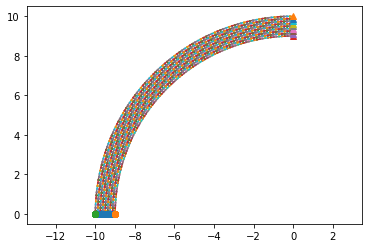

In [6]:
Plane2D.Plotmesh()

C:\Users\Admin\AppData\Local\Temp\ipykernel_26540\16214033.py:959: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  quadpoint[n,:]=[r1pt[i]]



Step 1 Load 0.05
Iteration number 1 Correction 1.0 Residual 4.818368743813376e-06 tolerance 0.0001
Iteration number 2 Correction 0.05405563628453598 Residual 0.00020487327921876546 tolerance 0.0001
Iteration number 3 Correction 0.08687276881144723 Residual 5.770629101993398e-07 tolerance 0.0001
Iteration number 4 Correction 0.00041134856966188734 Residual 1.3788924843782816e-06 tolerance 0.0001
Iteration number 5 Correction 5.562697730845641e-06 Residual 4.026063450811004e-11 tolerance 0.0001

Step 2 Load 0.1
Iteration number 1 Correction 0.535355768176851 Residual 4.818368744667965e-06 tolerance 0.0001
Iteration number 2 Correction 0.022314844296184806 Residual 0.0003255278379993612 tolerance 0.0001
Iteration number 3 Correction 0.06320016753806683 Residual 7.680030409979825e-07 tolerance 0.0001
Iteration number 4 Correction 0.00040913388165962167 Residual 3.932812621269015e-06 tolerance 0.0001
Iteration number 5 Correction 1.8037296601806426e-05 Residual 2.4000991310416026e-10 toler

Iteration number 1 Correction 0.04651685919306931 Residual 4.818196315110333e-06 tolerance 0.0001
Iteration number 2 Correction 0.0014292898124453402 Residual 0.0009705913188651869 tolerance 0.0001
Iteration number 3 Correction 0.0016646188178875791 Residual 2.419766201911312e-06 tolerance 0.0001
Iteration number 4 Correction 2.2727653390090223e-05 Residual 1.5369023365933865e-06 tolerance 0.0001

Step 17 Load 0.85
Iteration number 1 Correction 0.04101083120889787 Residual 4.81832457564395e-06 tolerance 0.0001
Iteration number 2 Correction 0.0011500735783479498 Residual 0.0007927417744951062 tolerance 0.0001
Iteration number 3 Correction 0.0013140123465843073 Residual 1.675964506612085e-06 tolerance 0.0001
Iteration number 4 Correction 1.1583110440322005e-05 Residual 1.0034943524974964e-06 tolerance 0.0001

Step 18 Load 0.9
Iteration number 1 Correction 0.036548259967844485 Residual 4.818356618069402e-06 tolerance 0.0001
Iteration number 2 Correction 0.0009473046505789433 Residual 0.00

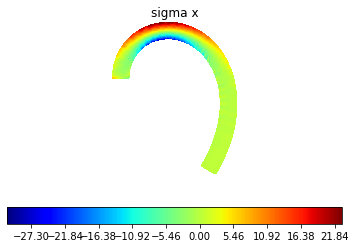

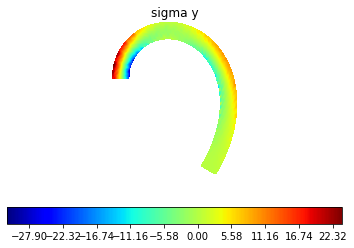

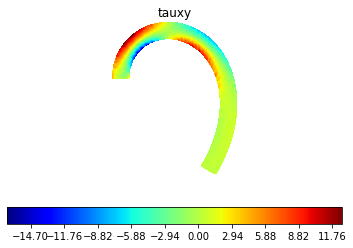

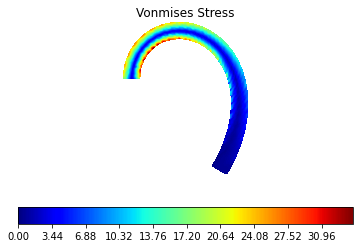

In [7]:
Plane2D.Calculate()